<a href="https://colab.research.google.com/github/msolorzan/TensorFlow-projects/blob/main/04_Transfer_Learning_in_TensorFlow_Part_1_Feature_extraction_Marco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

See full course materials on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/

In [ ]:
!nvidia-smi

Sat Oct 29 01:44:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101) - https://www.kaggle.com/dansbecker/food-101 
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-10-29 01:44:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.9MB/s    in 3.8s    

2022-10-29 01:44:43 (41.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/stea

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Set up data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')

print('Testing images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionized beause we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d - %H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard log files to: {log_dir}')
  return tensorboard_callback

> 🔑 **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() fuction to create a model from a URL
def create_model(model_url, num_classes = 10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
  model_url (str): A TensorFlow Hub feature extraction URL.
  num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
  An uncompiled Keras Sequential model with model_url as feature extractor
  layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                          trainable = False,# Freeze already learned pattern
                                          name = 'feature_extraction_layer',
                                          input_shape = IMAGE_SHAPE + (3,)) 

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our resnet model
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  validation_data = test_data,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                           experiment_name = 'resnet_v2_50')])

Saving Tensorboard log files to: tensorflow_hub/resnet_v2_50/20221029 - 014455
Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 1.9441 - accuracy: 0.3720 - val_loss: 1.2296 - val_accuracy: 0.6192
Epoch 2/5
24/24 [==============================] - 16s 667ms/step - loss: 0.9315 - accuracy: 0.7107 - val_loss: 0.8645 - val_accuracy: 0.7188
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6459 - accuracy: 0.8280 - val_loss: 0.7522 - val_accuracy: 0.7512
Epoch 4/5
24/24 [==============================] - 15s 659ms/step - loss: 0.4919 - accuracy: 0.8840 - val_loss: 0.7112 - val_accuracy: 0.7676
Epoch 5/5
24/24 [==============================] - 16s 667ms/step - loss: 0.3985 - accuracy: 0.9147 - val_loss: 0.6823 - val_accuracy: 0.7700


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt
import numpy as np

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
  history: TensorFlow History object.

  Returns:
  Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = np.arange(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = 'training_accuracy')
  plt.plot(epochs, val_accuracy, label = 'val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

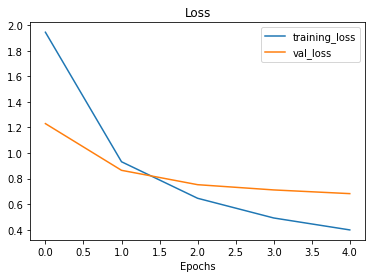

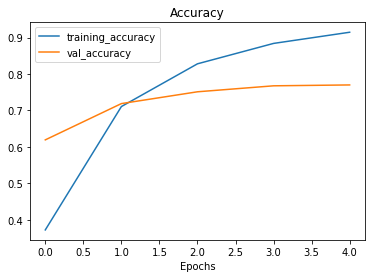

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficinetNetB0 feature extractor model - details on EfficientNet: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html#:~:text=EfficientNet%2DB0%20is%20the%20baseline,than%20the%20best%20existing%20CNN.
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes = train_data_10_percent.num_classes)

# Compile EddicientNet model
efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])
EPOCHS = 5

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs = EPOCHS,
                                              steps_per_epoch = len(train_data_10_percent),
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                                       experiment_name = 'efficientnetb0')])

Saving Tensorboard log files to: tensorflow_hub/efficientnetb0/20221029 - 014701
Epoch 1/5
24/24 [==============================] - 25s 709ms/step - loss: 1.9264 - accuracy: 0.3867 - val_loss: 1.3460 - val_accuracy: 0.7008
Epoch 2/5
24/24 [==============================] - 16s 679ms/step - loss: 1.0992 - accuracy: 0.7373 - val_loss: 0.8941 - val_accuracy: 0.8144
Epoch 3/5
24/24 [==============================] - 15s 643ms/step - loss: 0.7818 - accuracy: 0.8080 - val_loss: 0.7114 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 15s 646ms/step - loss: 0.6257 - accuracy: 0.8467 - val_loss: 0.6184 - val_accuracy: 0.8552
Epoch 5/5
24/24 [==============================] - 15s 634ms/step - loss: 0.5281 - accuracy: 0.8853 - val_loss: 0.5640 - val_accuracy: 0.8592


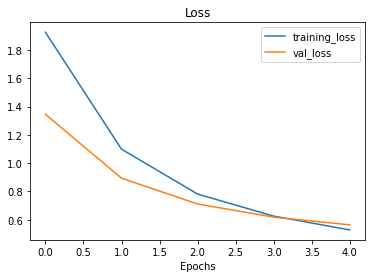

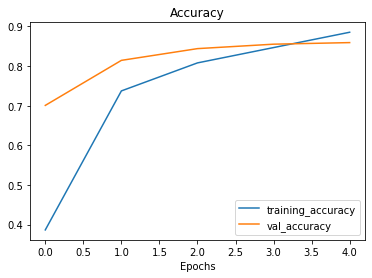

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# How many layers does our efficientnetb0 feature extractor have?


## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to [TensorBoard.dev](https://tensorboard.dev/), you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/dQBrpdwIRgS2qI0Andv8Yg/

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/PQ5E9waORKeu7mAAk1Vhgg/

[2022-10-29T01:49:09] Started scanning logdir.
[2022-10-29T01:49:14] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.6 MB)
[2022-10-29T01:49:14] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/PQ5E9waORKeu7mAAk1Vhgg/


In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/PQ5E9waORKeu7mAAk1Vhgg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   PQ5E9waORKeu7mAAk1Vhgg
	Created              2022-10-29 01:49:09 (1 minute ago)
	Updated              2022-10-29 01:49:14 (1 minute ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918466
https://tensorboard.dev/experiment/XVRTrZmNQXWqPYIlSm7mYQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   XVRTrZmNQXWqPYIlSm7mYQ
	Created              2022-10-29 01:48:36 (2 minutes ago)
	Updated              2022-10-29 01:48:42 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor byte

In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id XVRTrZmNQXWqPYIlSm7mYQ


Deleted experiment XVRTrZmNQXWqPYIlSm7mYQ.


In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/PQ5E9waORKeu7mAAk1Vhgg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   PQ5E9waORKeu7mAAk1Vhgg
	Created              2022-10-29 01:49:09 (7 minutes ago)
	Updated              2022-10-29 01:49:14 (7 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918466
Total: 1 experiment(s)
